# Outline 

- [Exploring the dataset](#Exploring-the-dataset)
  - [Loading the dataset](#Loading-the-dataset)
  - [Adding a new categorical feature](#Adding-a-new-categorical-feature)
- [Visualization](#Visualization)
  - [Count plot for a categorical variable](#Count-plot-for-a-categorical-variable)
  - [Numerical variable distribution](#Numerical-variable-distribution)
  - [Boxplots](#Boxplots)
- [Preprocessing the data](#Preprocessing-the-data)
  - [Preprocessing categorical variables](#Preprocessing-categorical-variables)
  - [Preprocessing numerical variables](#Preprocessing-numerical-variables)
- [Finetuning a Supervised Model](#Finetuning-a-Supervised-Model)
  - [Evaluation Metrics](#Evaluation-Metrics)
  - [Fine Tuning Random Forest](#Fine-Tuning-Random-Forest)
- [Adjusting the threshold](#Adjusting-the-threshold)
  - [A small review](#A-small-review)
  - [Adjusting the probability threshold](#Adjusting-the-probability-threshold)

### Loading the dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl 
plt.style.use("dark_background")

In [7]:
df = pd.read_csv("../data/credit_dataset.csv", index_col=0)

In [9]:
df = df.sample(frac=1).reset_index(drop=True) # randomly shuffle rows of the df
df.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,39,170000,MORTGAGE,16.0,MEDICAL,A,32000,7.49,0,0.19,N,13
1,23,55000,MORTGAGE,7.0,VENTURE,A,5200,8.90,0,0.09,N,4
2,22,12600,RENT,2.0,PERSONAL,B,4000,10.37,1,0.32,N,4
3,33,30000,RENT,0.0,PERSONAL,A,6500,8.49,0,0.22,N,5
4,24,85000,MORTGAGE,4.0,DEBTCONSOLIDATION,B,15000,9.88,0,0.18,N,3


In [10]:
# Check for amount of rows and for any missing values 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           32581 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               32581 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [12]:
#create quickaccess list with categorical variables labels
catvars = list(df.select_dtypes(include = 'object').columns)
#create quickaccess list with numerical variables labels
numvars = list(df.select_dtypes(exclude = 'object').columns)
numvars.remove("loan_status")

In [13]:
# Threshold, splitting 70% train, 30% testing
threshold = 0.7*len(df)

# Splitting the dataset
df_train = df.loc[:threshold].reset_index(drop=True)
df_test = df.loc[threshold:].reset_index(drop=True)

In [14]:
print("We have {} training samples".format(len(df_train)))
print("We have {} testing samples".format(len(df_test)))

We have 22807 training samples
We have 9774 testing samples


### 1.2 Adding a new categorical feature

In [15]:
# Describe numerical features of the training set
df_train[numvars]
df_train[numvars].describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,22807.000000,2.280700e+04,22807.000000,22807.000000,22807.000000,22807.000000,22807.000000
mean,27.746131,6.617714e+04,4.787784,9628.008945,11.010611,0.170186,5.809050
std,6.364268,6.498585e+04,4.005592,6347.400791,3.073599,0.106508,4.056826
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
25%,23.000000,3.900000e+04,2.000000,5000.000000,8.490000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12250.000000,13.110000,0.230000,8.000000
max,144.000000,6.000000e+06,41.000000,35000.000000,23.220000,0.830000,30.000000


---
Create a new categorical feature named `category_income` assigning a category 'A', 'B', 'C' and 'D' according to the feature `person_income` as follows:
  * If `person_income` is in [0, 39000], then `category_income = 'D'`.
  * If `person_income` is in [39000, 55000], then `category_income = 'C'`.
  * If `person_income` is in [55000, 79000], then `category_income = 'B'`.
  * If `person_income` is in [79000, +$\infty$], then `category_income = 'A'`.
---

In [16]:
df_train["person_income"].describe()

count    2.280700e+04
mean     6.617714e+04
std      6.498585e+04
min      4.000000e+03
25%      3.900000e+04
50%      5.500000e+04
75%      7.920000e+04
max      6.000000e+06
Name: person_income, dtype: float64

In [17]:
# Income intervals
intervals = (0, 39000, 55000, 79000, 6000000)
# Categories
categories = ["D", "C", "B", "A"]
# Create the new feature
df_train["category_income"] = pd.cut(df_train.person_income, intervals, labels=categories)
df_test["category_income"] = pd.cut(df_test.person_income, intervals, labels=categories)
# Add the new category `category_income` to the list of categorical variables
catvars.append("category_income")

# 2. Visualization

In [18]:
# The different values of person_home_ownsership
df_train["person_home_ownership"].unique()

array(['MORTGAGE', 'RENT', 'OWN', 'OTHER'], dtype=object)

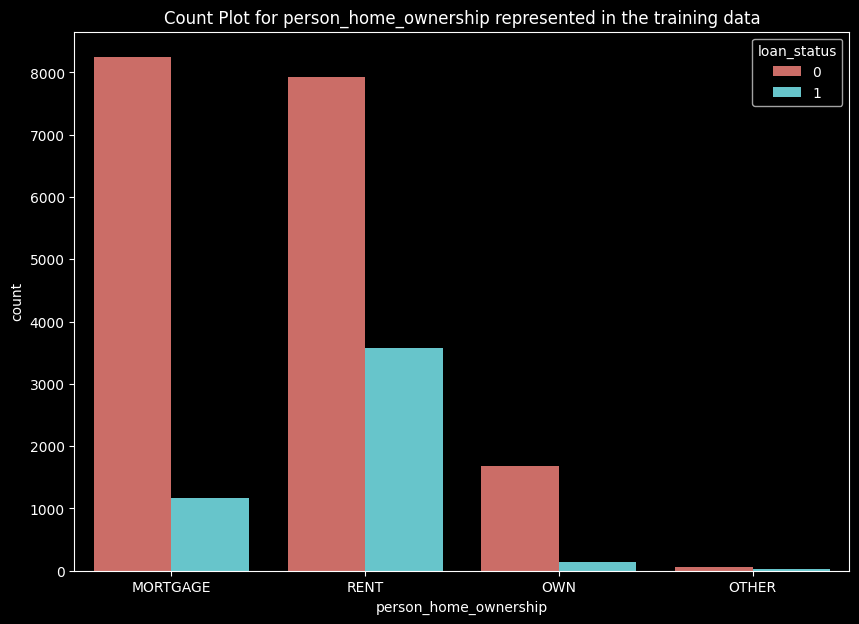

In [19]:
fig = plt.figure(figsize=(10, 7))
g = sns.countplot(x="person_home_ownership", data=df_train, palette="hls", hue="loan_status")
g.set_title("Count Plot for person_home_ownership represented in the training data")
plt.show()

### 2.2 Numerical variable distribution

We want to plot a univariate distribution of a numerical variable associated to the "0" and "1" targets. 

<Figure size 1400x700 with 0 Axes>

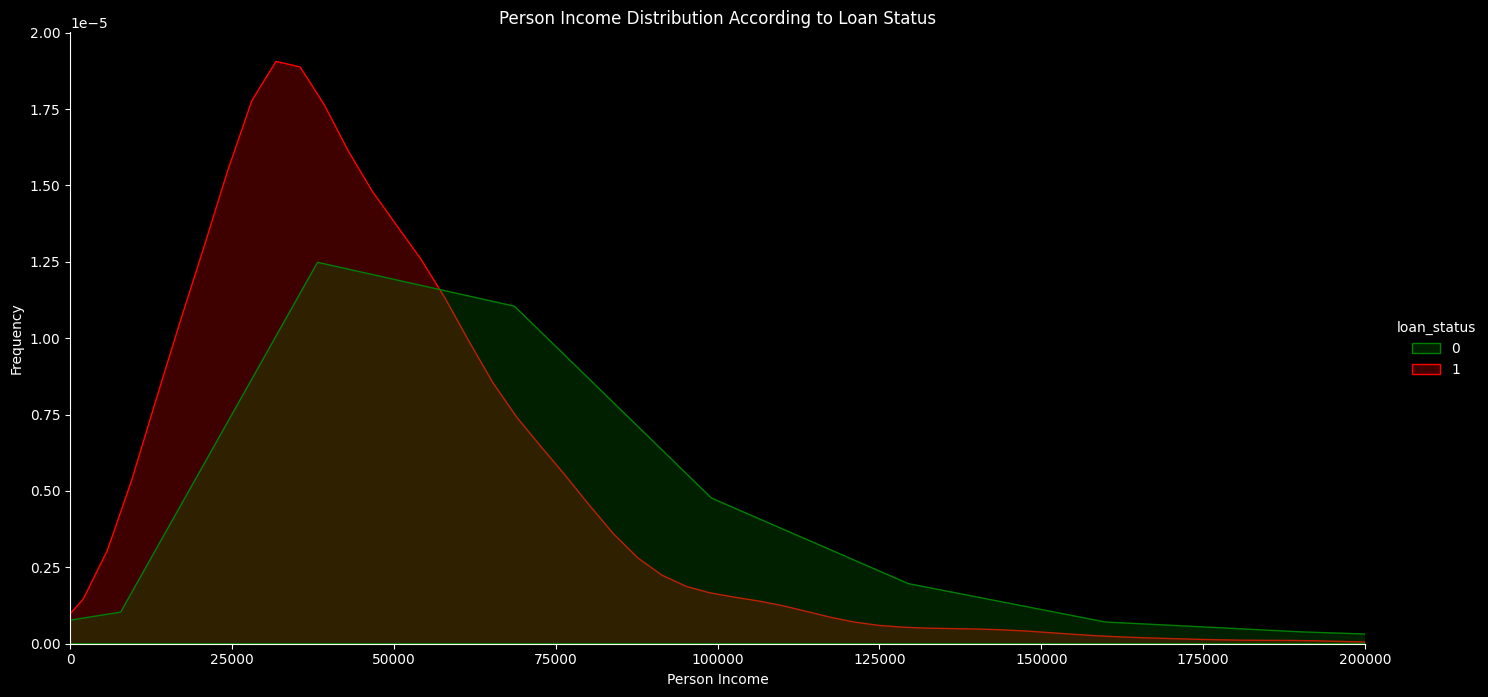

In [27]:
plt.figure(figsize=(14, 7))

sns.displot(data=df_train, x="person_income", hue="loan_status", kind="kde", 
            fill=True, common_norm=False, palette=["g", "r"], height=7, aspect=2)

plt.xlabel("Person Income")
plt.xlim(0, 200000)
plt.ylabel("Frequency")
plt.title("Person Income Distribution According to Loan Status")
plt.show()

---

We can see that the distribution of `person_income` associated the target '0' (No default) is shifted to the right, in comparison with the one associated with the target '1' (default).

---

### 2.3 Boxplots 

---

The distribution of the numerical feature `loan_amnt` according to the new categorical variable `category_income` and the targets `loan_status`. 

---

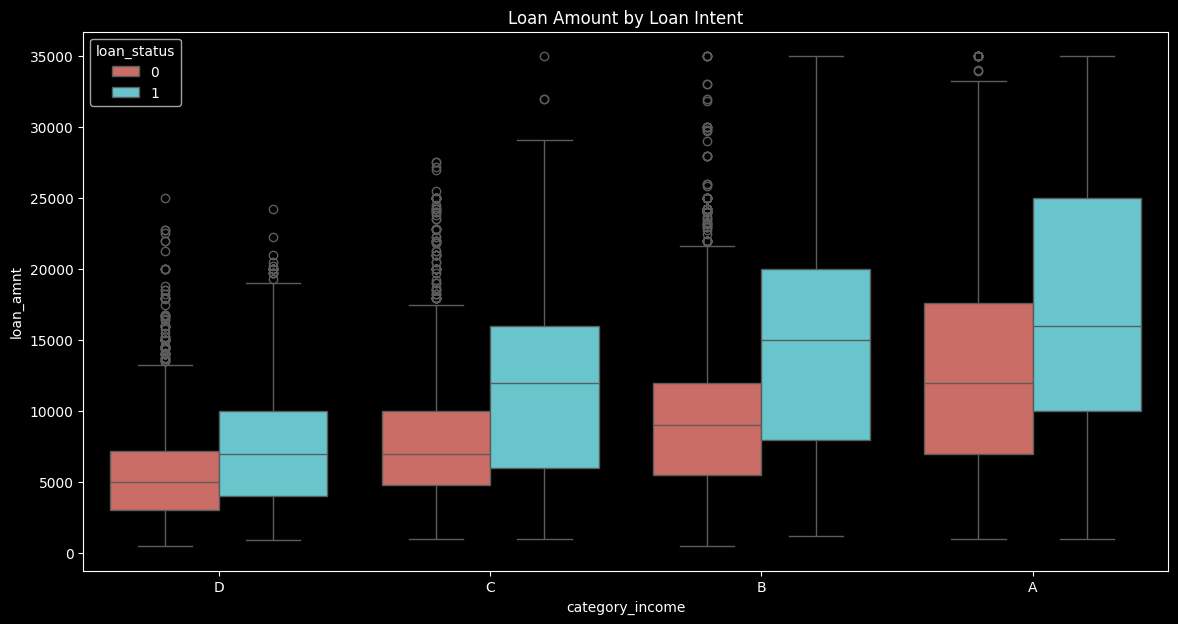

In [28]:
fig = plt.figure(figsize=(14, 7))
g = sns.boxplot(x="category_income", y="loan_amnt", data=df_train, palette="hls",hue="loan_status")
g.set_title("Loan Amount by Loan Intent")
plt.show()

# 3. Preprocessing the data

### 3.1. Preprocessing categorical variables 

* Let's suppose we have a categorical variable X that can take K different values $\{1, \dots, K\}$

* **One hot encoding** a category consists in transforming the category into a vector $\in \mathbb{R}^K$ where we have 1 in the position of the category and zeros elswhere. 

* For instance, if $K=4$, the category "3" for one sample is one hot encoded into the vector $[0, 0, 1, 0]$


* Therefore, we can turn a catogorical feature into K features. 

* As each sample is only mapped to one category, the K features are not independent (the K-th feature can be deduced from the K-1 first features). Therefore, we usually drop one of the columns.

The categories:

In [ ]:
catvars

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file',
 'category_income']

In [1]:
for categorical_variable in catvars:
  print(f"Feature: {categorical_variable} ... Categories: {df_train[categorical_variable].unique()}")

NameError: name 'catvars' is not defined

The number of categories:

In [ ]:
# For each categorical variable, the number of possible categories
df_train[catvars].nunique()

person_home_ownership        4
loan_intent                  6
loan_grade                   7
cb_person_default_on_file    2
category_income              4
dtype: int64

In [ ]:
# 1 for target (loan_status)
# 5 categorical variables
# 7 numerical variables 
df_train.shape

(22807, 13)

In [31]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(df_train[catvars])

# Create a DataFrame with the one-hot encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names(catvars))

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_train = pd.concat([df_train.drop(columns=catvars), encoded_df], axis=1)


[array(['person_home_ownership'], dtype=object),
 array(['loan_intent'], dtype=object),
 array(['loan_grade'], dtype=object),
 array(['cb_person_default_on_file'], dtype=object)]

In [ ]:
df_test = pd.get_dummies(df_test,
                         columns=catvars,
                         dummy_na=False,
                         drop_first=True)

In [ ]:
catvars

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file',
 'category_income']

---
<font color=green>Q22:</font>
<br><font color='green'>
Explain the new shape of `df_train` after the one hot encoding ?
</font>

---

<center><img width="1000" src = "https://drive.google.com/uc?export=view&id=1eEOIb904c2UOT82AUYdjaZINj9rVr1Ji"></center>

In [ ]:
df_train.shape

(22807, 26)

---
* Number of Dummy variables: 18.
  * person_home_ownership     ---->   4 possible values ----> 3 Dummy variables 
  * loan_intent               ---->   6 possible values ----> 5 Dummy variables
  * loan_grade                ---->   7 possible values ----> 6 Dummy variables
  * cb_person_default_on_file ---->   2 possible values ----> 1 Dummy variable
  * category_income           ---->   4 possible values ----> 3 Dummy variables

* Number of Numerical variables: 7. 

* One column for the target `loan_status`. 

* Total number of columns: 26
---

In [ ]:
df_train.head(10)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y,category_income_C,category_income_B,category_income_A
0,23,30000,0.0,5000,11.86,0,0.17,2,0,0,...,1,0,0,0,0,0,0,0,0,0
1,21,19200,5.0,3300,6.17,1,0.17,2,0,1,...,0,0,0,0,0,0,0,0,0,0
2,23,125000,6.0,35000,8.90,0,0.28,4,0,0,...,0,0,0,0,0,0,0,0,0,1
3,24,48000,0.0,2400,12.99,0,0.05,4,0,0,...,0,1,0,0,0,0,1,1,0,0
4,26,120000,10.0,5000,13.49,0,0.04,2,0,0,...,0,1,0,0,0,0,1,0,0,1
5,22,30000,3.0,8000,12.53,0,0.27,2,0,0,...,1,0,0,0,0,0,0,0,0,0
6,26,60000,0.0,5000,7.14,0,0.08,2,0,0,...,0,0,0,0,0,0,0,0,1,0
7,34,357000,3.0,14000,18.64,0,0.04,9,0,0,...,0,0,0,1,0,0,1,0,0,1
8,24,36000,2.0,5200,9.91,0,0.14,3,0,0,...,1,0,0,0,0,0,0,0,0,0
9,23,20004,6.0,7125,6.99,0,0.36,2,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.2 Preprocessing Numerical Variables

---
<font color=green>Q23:</font>
<br><font color='green'>
Split `df_train` into `df_train_features` and `df_train_targets` and `df_test` into `df_test_features` and `df_test_targets` as shown in the figure below.
</font>

---

<center><img width="1000" src = "https://drive.google.com/uc?export=view&id=1V0Sjgbbef6mdNSAwKAUQLeJlOWJU-3np"></center>

In [ ]:
df_train_targets = df_train['loan_status']
df_train_features = df_train.drop('loan_status',axis=1)

df_test_targets = df_test['loan_status']
df_test_features = df_test.drop('loan_status',axis=1)

---
<font color=green>Q24:</font>
<br><font color='green'>
Split each of `df_train_features` and `df_test_features` as shown in the figure below:

* `df_train_features_numvars` and `df_test_features_numvars` containing the training abd testing numerical features
* `df_train_features_rest` and `df_train_features_rest` containing the rest of the features.
</font>

---

<center><img width="1000" src = "https://drive.google.com/uc?export=view&id=1loF_Uk967CSVlGKikXWbDxwpKAEGaDlg"></center>

In [ ]:
df_train_features_numvars = df_train_features[numvars]
df_train_features_rest = df_train_features[df_train_features.columns[~df_train_features.columns.isin(numvars)]]


df_test_features_numvars = df_test_features[numvars]
df_test_features_rest = df_test_features[df_test_features.columns[~df_test_features.columns.isin(numvars)]]

---
<font color=green>Q25:</font>
<br><font color='green'>
Plot the histograms of the numerical variables `df_train_features_numvars` using `dataframe.hist()`
</font>

---

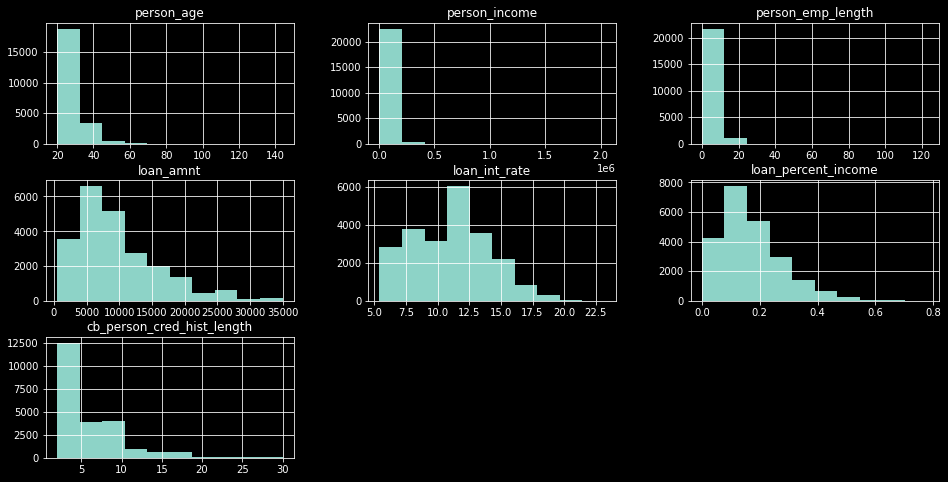

In [ ]:
df_train_features_numvars.hist(figsize=(16, 8))
plt.show()

There are two ways of scaling a numerical variable:

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1UiUAyNligNF9TQkavRdatKR-4WI3pxqz"></center>

---
<font color=green>Q26:</font>
<br><font color='green'>
From `sklearn.preprocessing`, scale the numerical features using one of the two scaling methods:
  * `StandardScaler()` to get a distribution with a mean = 0 and std = 1.
  * `MinMaxScaler()` to map the data to the range [0, 1]
</font>

---

<center><img width="1000" src = "https://drive.google.com/uc?export=view&id=1b2nPF0z0eMVwvH3g5Yu40AtKaQHFlMUa"></center>

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Instantiate models
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
# Fit and Transform the training numerical variables using StandardScaler
df_train_features_numvars_std = pd.DataFrame(standard_scaler.fit_transform(df_train_features_numvars))
# Transform the testing numerical variables using StandardScaler
df_test_features_numvars_std = pd.DataFrame(standard_scaler.transform(df_test_features_numvars)) 

# Fit and Transform the training numerical variables using MinMaxScaler
df_train_features_numvars_minmax = pd.DataFrame(minmax_scaler.fit_transform(df_train_features_numvars))
# Transform the testing numerical variables using MinMaxScaler
df_test_features_numvars_minmax = pd.DataFrame(minmax_scaler.transform(df_test_features_numvars)) 

---
<font color=green>Q27:</font>
<br><font color='green'>
Plot the histograms of the numerical features after the scaling process.
</font>

---

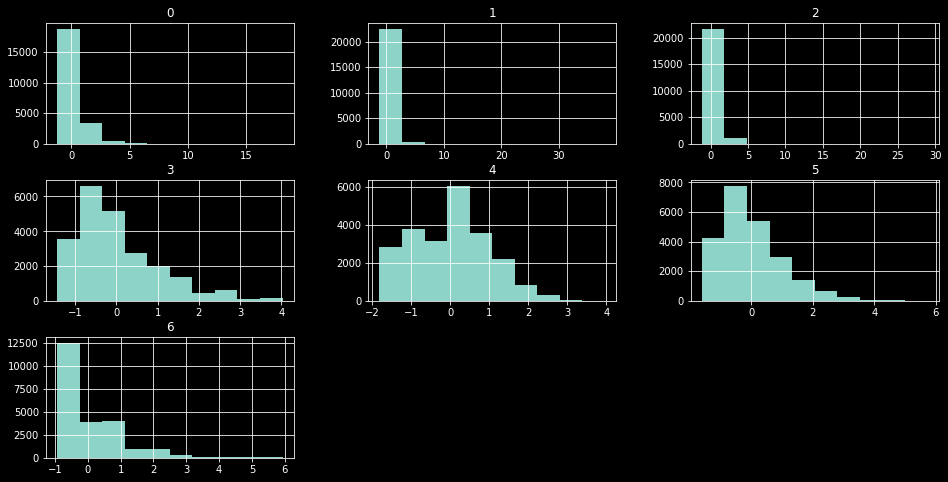

In [ ]:
df_train_features_numvars_std.hist(figsize=(16, 8))
plt.show()

---
<font color=green>Q28:</font>
<br><font color='green'>
Concatenate `df_train_features_rest` with your scaled dataframe of numerical features `df_train_features_numvars_std` to get the final dataframe `df_train_features_processed`. Same for the test data as shown in the figure below.
</font>

---

<center><img width="1000" src = "https://drive.google.com/uc?export=view&id=1VgznTzwgu32QTb6bjxdDzvu8gF5PyEvt"></center>

In [ ]:
df_train_features_processed = pd.concat([df_train_features_numvars_std, df_train_features_rest], axis=1) 
df_test_features_processed = pd.concat([df_test_features_numvars_std, df_test_features_rest], axis=1)

---
<font color=green>Q29:</font>
<br><font color='green'>
Show the first 5 rows of the new dataset
</font>

---

In [ ]:
df_train_features_processed.head(5)

,0,1,2,3,4,5,6,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,...,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y,category_income_C,category_income_B,category_income_A
0,-0.740044,-0.688385,-1.169786,-0.725875,0.274137,-0.002054,-0.935119,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,-1.051338,-0.896450,0.055362,-0.995317,-1.574400,-0.002054,-0.935119,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.740044,1.141813,0.300391,4.028983,-0.687492,1.030469,-0.444538,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.584397,-0.341611,-1.169786,-1.137963,0.641246,-1.128442,-0.444538,0,0,1,...,0,1,0,0,0,0,1,1,0,0
4,-0.273104,1.045486,1.280510,-0.725875,0.803683,-1.222307,-0.935119,0,0,0,...,0,1,0,0,0,0,1,0,0,1


---
<font color=green>Q30:</font>
<br><font color='green'>
What are the shapes of `df_train_features_processed`, `df_train_targets`, `df_test_features_processed` and `df_test_targets`
</font>

---

In [ ]:
df_train_features_processed.shape

(22807, 25)

In [ ]:
df_train_targets.shape

(22807,)

In [ ]:
df_test_features_processed.shape

(9774, 25)

In [ ]:
df_test_targets.shape

(9774,)

---
<font color=green>Q31:</font>
<br><font color='green'>
Convert the aforementioned dataframes into `numpy` arrays to get `X_train`, `X_test`, `y_train`, `y_test`.
</font>

---

In [ ]:
X_train = df_train_features_processed.values
X_test = df_test_features_processed.values

y_train = df_train_targets.values
y_test = df_test_targets.values

# 4. Fine Tuning a Supervised Model

### 4.1 Evaluation Metrics

First, let's start by a review of the different evaluation metrics

<center><img width="700" src = "https://drive.google.com/uc?export=view&id=1SbB_CEcOCblu1sUwzGAOwn5oQRQGEQxS"></center>

The F1 score is calculated as follows: 

$$
\text{F1} = 2 \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
$$

---
<font color=green>Q32:</font>
<br><font color='green'>
What is the distribution of the targets `loan_status` ?
</font>

---

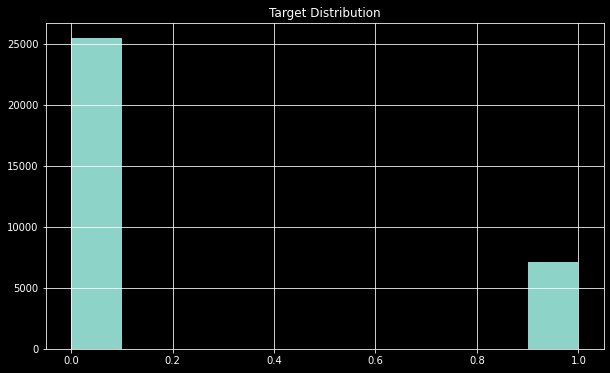

In [ ]:
df["loan_status"].hist(figsize=(10, 6))
plt.title("Target Distribution")
plt.show()

---
<font color=green>Q33:</font>
<br><font color='green'>
Which of the two errors is the most dangerous one for the credit problem ? 
</font>

---

---
The dataset is imbalanced, we should avoid optimizing the **accuracy score**.

The worst error is to predict a negative class (no default) to a sample that is actually in the positive class (i.e default). 

Therefore, the metric we should optimize is the recall.

---

A brief review of Cross Validation:

<center><img width="700" src = "https://drive.google.com/uc?export=view&id=1TQfP49ZaOoAq4Egt0NuIsWYLHb8Maris"></center>

---
<font color=green>Q34:</font>
<br><font color='green'>
Using `cross_val_score` from `sklearn.model_selection`, write a function that takes as inputs the **classifier**, the **training features** and the **training targets**. The function should output the distribution (the mean and the std) of the following performance measures using cross validation (with K=5). 

* Presicion
* Recall
* f1 score
* auc
* accuracy
</font>

---

In [ ]:
# Import module 
from sklearn.model_selection import cross_val_score
# Cross Validation to test and anticipate overfitting problem
def crossvalidate(clf, X, y):
    precision = cross_val_score(clf, X, y, cv=5, scoring='precision')
    recall = cross_val_score(clf, X, y, cv=5, scoring='recall')
    f1 = cross_val_score(clf, X, y, cv=5, scoring='f1')
    roc_auc = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
    accuracy = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std()))
    print("Cross Validation f1 score: %0.2f (+/- %0.2f)" % (f1.mean(), f1.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (roc_auc.mean(), roc_auc.std()))
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (accuracy.mean(), accuracy.std()))

---
<font color=green>Q35:</font>
<br><font color='green'>
Using `confusion_matrix` from `sklearn.metrics`, write a function that takes as inputs `y_test` and `y_hat` (vector of 0-1). The function should output a plot of the confusion matrix on the test set. 
</font>

---

In [ ]:
# Import module
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_hat):
  fig = plt.figure(figsize=(10, 8))
  g = sns.heatmap(confusion_matrix(y_test, y_hat),
              annot=True,
              fmt="0.0f")
  g.set_xlabel("Predicted")
  g.set_ylabel("Actual")
  g.set_title("Confusion Matrix on the test set")
  plt.show()



### 4.2 Fine Tuning Random Forest

Brief review of Hyperparameters Optimization:

<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1j93wPCK9TyV0oi_kj-UhijNJTLafH4fa"></center>

We would like to tune the following hyperparameters:

* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* bootstrap = method for sampling data points (with or without replacement)

---
<font color=green>Q36:</font>
<br><font color='green'>
Define a dictionary called `random_grid` which maps each of the hyperparameters to a list of possibilities. Example:
* "n_estimators" : [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
* "max_features" : ["auto", "sqrt"]
* "max_depth" : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
* "bootstrap" : [True, False]
</font>

---

In [ ]:
[int(x) for x in np.linspace(10, 110, num = 11)]

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]

In [ ]:
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 400, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 35, 60, 85, 110, None],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [200, 250, 300, 350, 400]}


---
<font color=green>Q37:</font>
<br><font color='green'>
Using `RandomizedSearchCV` from `sklearn.model_selection` and `RandomForestClassifier` from `sklearn.ensemble`, find the best combination of hyperparameters among 20 possibilities.

</font>

---

In [ ]:
# Import Modules 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
model_rf = RandomForestClassifier(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model_rf, 
                               param_distributions = random_grid, 
                               n_iter = 5, 
                               cv = 3, 
                               verbose=2, 
                               scoring="f1",
                               random_state=42, 
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 35, 60, 85, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [200, 250, 300, 350,
                                                         400]},
                   random_state=42, verbose=2)

---
<font color=green>Q38:</font>
<br><font color='green'>
What are the hyperparameters of the best model `rf_best`?

</font>

---

In [ ]:
rf_random.best_estimator_

RandomForestClassifier(max_features='sqrt', n_estimators=200, random_state=42)

In [ ]:
rf_best = rf_random.best_estimator_

---
<font color=green>Q39:</font>
<br><font color='green'>
Using `classification_report` from `sklearn.metrics`, display the different performance measures and the confusion matrix for the "optimal" model `rf_best`. 
</font>

---

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7680
           1       0.96      0.72      0.82      2094

    accuracy                           0.93      9774
   macro avg       0.94      0.86      0.89      9774
weighted avg       0.94      0.93      0.93      9774



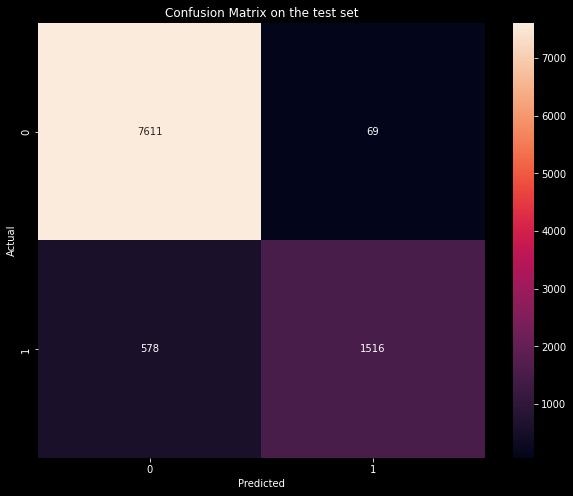

In [ ]:
# Evaluation performances
from sklearn.metrics import classification_report
y_hat = rf_best.predict(X_test)
print(classification_report(y_test, y_hat))
# Confusion Matrix
plot_confusion_matrix(y_test, y_hat)

# 5. Adjusting the threshold

### 5.1 A small review



As explained in Lecture 1, the AUC is defined as the area under the curve, i.e, the area between the curve and the x-axis. 

* Let us consider a dataset $\mathcal{S} = \{ (x_1, y_1), \dots, (x_n, y_n) \}$ where $\forall i \in \{1, \dots, n\} \quad x_i \in \mathbb{R}^d, \ y_i \in \{0, 1\} \}$

* A classification algorithm (like Random Forest), trained on $\mathcal{S}$, maps each new obersvation $x^* \in \mathbb{R}^d$ to a score $\hat{p}(x^*) \in [0, 1]$ signifying the algorithm's confidence that the label of $x^*$ is $y^* = 1$. 


* Let us split the training feature vectors  $\{(x_i)\}_{1 \leq i \leq n}$ into two groups:
  * A group $\mathcal{G}_+$ of feature vectors associated with the positive label.  
  * A group $\mathcal{G}_-$ of feature vectors associated with the negative label.

* We can then represent two distribution of scores: 
  * A distribution of the scores $\hat{p}(x)$ for each $x \in \mathcal{G}_+$ 
  * A distribution of the scores $\hat{p}(x)$ for each $x \in \mathcal{G}_-$ 

* The figure below summarizes the process described. 

<center><img width="700" src = "https://drive.google.com/uc?export=view&id=17AynSe1QDaiZR-_9FpVQMfOzKRdR_Lfi"></center>

* Let us represent the two distributions in one figure: 

<center><img width="700" src = "https://drive.google.com/uc?export=view&id=1tKSqfs1ITKikr8F4oaRSs6t2HLN0hIIf"></center>


* The **AUC** can be interpreted as a measure of the quality of seperation between the aforementioned distributions. 

* Mathematically speaking, the **AUC** gives the probability that the classifier gives a higher score to a positive sample than to a negative sample. (you can read the proof in the [optional reading](https://colab.research.google.com/drive/1gcbB3-3Y6AfohDFJYKmFPF2G-4EIPDTi?usp=sharing)). 




* The method `rf_best.predict_proba()` maps each element $x$ to a prediction (or a score) $p(x) \in [0, 1]$ reflecting the confidence of the classifier in assigning the target $y=1$ to the feature vector $x$. 


<center><img width=“500" src = "https://drive.google.com/uc?export=view&id=1znqNbk_1GLWeTgxf3PU0HcGg1r1L-uLo"></center>


* In order to convert the continuous prediciton $p(x)$ into a binary prediction $\hat{y} \in \{0, 1 \}$, we need to choose a **threshold** above which we assign the positive label.

* The default threshold is 0.5 and the method used to map $x$ to a binary output with this default threshold 0.5 is `rf_best.predict()`

### 5.2 Adjusting the probability threshold

**Our objective in this section is to adjust the threshold in order to match a desired recall**

In order to plot the ROC curve, you will have to install `plot_metric` using the following command line:

```
!pip install plot_metric
```

In [ ]:
!pip install plot_metric

---
<font color=green>Q40:</font>
<br><font color='green'>
Plot the ROC curve of the best model `rf_best` using `BinaryClassification` from `plot_metric.functions`
</font>

---


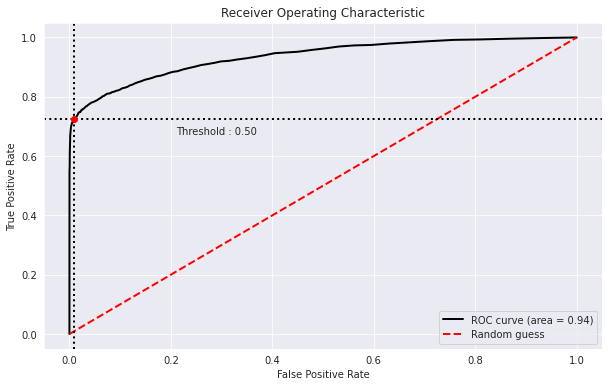

In [ ]:
# Import module
from plot_metric.functions import BinaryClassification

# Plot the ROC curve
bc = BinaryClassification(y_test, rf_best.predict_proba(X_test)[:, 1], labels=[0, 1])
plt.figure(figsize=(10, 6))
bc.plot_roc_curve()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
y_hat = rf_best.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7680
           1       0.96      0.72      0.82      2094

    accuracy                           0.93      9774
   macro avg       0.94      0.86      0.89      9774
weighted avg       0.94      0.93      0.93      9774



---
<font color=green>Q41:</font>
<br><font color='green'>
Let us fix an objective recall of 0.8. By decreasing the threshold progressively from 1 to 0, determine the maximum threshold for which we can have a recall of 0.8, called `best_threshold`
</font>

---


In [ ]:
# Let us find the threshold with the highest recall
from sklearn.metrics import recall_score
# Calculate the prediction scores y_hat_proba associated with X_test
y_hat_proba = rf_best.predict_proba(X_test)[:, 1]

# The objective recall
OBJECTIVE_RECALL = 0.8

# Initialize the best threshold to 0.5
best_threshold = 0.5
# Calculate the binary prediction y_hat associated with the threshold 0.5
y_hat = (y_hat_proba > best_threshold)
# Calculate the recall associated with the threshold 0.5
best_recall = recall_score(y_test, y_hat)

# Find the best threshold 
for th in np.arange(0.01, 1, 0.01)[::-1]:
  # Calculate the binary prediction y_hat associated with the threshold th
  y_pred = (y_hat_proba > th)
  recall = recall_score(y_test, y_pred)
  if recall > OBJECTIVE_RECALL:
    best_recall = recall
    best_threshold = th
    break
print("The best Threshold is {}...The best recall is {}".format(best_threshold, best_recall))

The best Threshold is 0.27...The best recall is 0.8013371537726839


---
<font color=green>Q42:</font>
<br><font color='green'>
Plot the ROC curve and show the point with the coordinated (FPR(best_threshold), TPR(best_treshold)). 
</font>

---

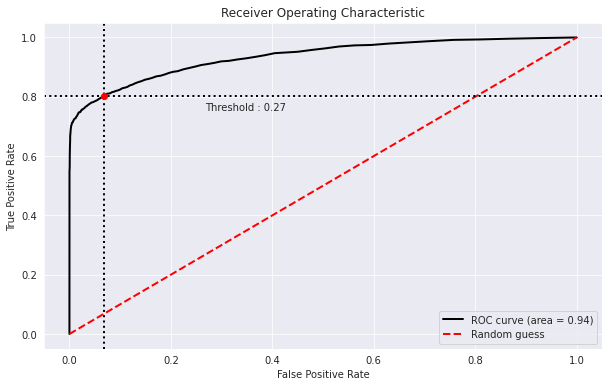

In [ ]:
# let's use another probability threshold so that we can get to the elbow position in the above curve
bc = BinaryClassification(y_test, rf_best.predict_proba(X_test)[:, 1], threshold=best_threshold, labels = [0, 1])
plt.figure(figsize=(10, 6))
bc.plot_roc_curve()
plt.show()

---
<font color=green>Q43:</font>
<br><font color='green'>
Plot the confusion matrix associated with `best_threshold`
</font>

---


In [ ]:
# Calculate the prediction scores y_hat_proba associated with X_test
y_hat_proba = rf_best.predict_proba(X_test)[:, 1]

In [ ]:
# Calculate the binary prediction y_hat associated with the threshold th
y_hat = (y_hat_proba >= best_threshold)

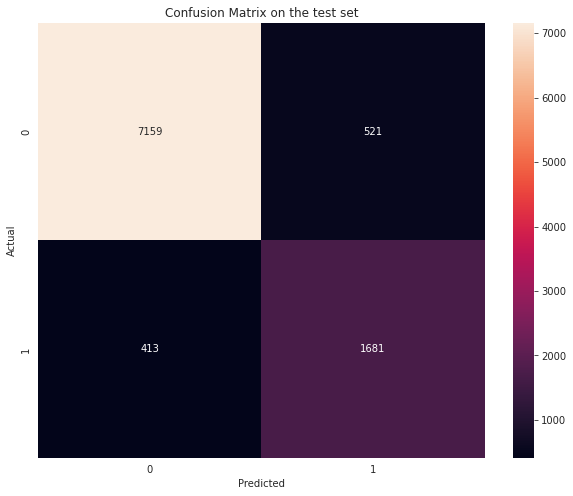

In [ ]:
# plot the confusion matrix
fig = plt.figure(figsize=(10, 8))
g = sns.heatmap(confusion_matrix(y_test, y_hat),
            annot=True,
            fmt="0.0f")
g.set_xlabel("Predicted")
g.set_ylabel("Actual")
g.set_title("Confusion Matrix on the test set")
plt.show()

---
<font color=green>Q44:</font>
<br><font color='green'>
Print the evaluation metrics associated with `best_threshold`
</font>

---
 

In [ ]:
# print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7680
           1       0.76      0.80      0.78      2094

    accuracy                           0.90      9774
   macro avg       0.85      0.87      0.86      9774
weighted avg       0.91      0.90      0.91      9774



# Wrap-up

During this session we learned:
* How to load and visualize a dataset.
* How to process categorical and numerical features.
* What are the most suitable evaluation metrics in the case of an imbalanced dataset, especially the recall and the AUC.
* How to adjust the probability threshold so that it matches the objective error of a business problem.

# Optional Exercise: Resampling techniques

* The main problem when we train a model using an imbalanced dataset is that it results in a biased classifier towards the majority class. 

* There are two ways to overcome this bias problem:
  * **Undersampling**: In this case, we randomly select as many observations of the majority class $\mathcal{G}_-$ as we have for the minority class $\mathcal{G}_+$. (See figure below)
  
  <center><img width=“500" src = "https://drive.google.com/uc?export=view&id=106_U8l014dk7LybyoPpUEiLlABfeWbhZ"></center>

  * **Oversampling**: In this case, we prefer to have more elements from the minority class $\mathcal{G}_+$. Hence, we either create duplicates of the minority class or create synthetic datapoints so that we reach $|\mathcal{G}_-|$ samples (where $|F|$ denotes the number of elements of $F$). One way of creating synthetic data points is called the **SMOTE** (Synthetic Minority Oversampling Technique). The method is described in [Synthetic Minority Over-sampling Technique](https://arxiv.org/pdf/1106.1813.pdf) and can be summarized as follows:
    * First, a random example $x_1$ is chosed from the minority class $\mathcal{G}_+$. 
    * Then, we find the k nearest neighbors for that example (typically $k=5$).
    * We randomly select one of these k neighbors, let's call it $x_2$.
    * The synthetic instances are generated as a convex combination of the two instances $x_1$ and $x_2$. 

  <center><img width=“500" src = "https://drive.google.com/uc?export=view&id=1j2EGBKoXKdI66mynmgdIYlRT2HWpdhrQ"></center>


---
<font color=green>Optional questions:</font>
<br><font color='green'>
* Finetune the model after using the SMOTE oversampling method. 
* Try different supervised models to improve the results. 
</font>

---
